# T017 · Advanced NGLview usage

Authors:

- Jaime Rodríguez-Guerra, 2021, Volkamer Lab, Charité Universitätsmedizin
- Dominique Sydow, 2021, Volkamer Lab, Charité Universitätsmedizin

## Aim of this talktorial

[NGLView](http://nglviewer.org/nglview/latest/) is a powerful Jupyter widget that allows you to show molecular structures in your notebooks in a 3D interactive view! It supports both single conformations and trajectories, as well as a plethora of representations. In this talktorial we will cover how to use it in different scenarios, from simpler cases to more intricate ones.

### Contents in *Theory*

* NGL and NGLView
* Jupyter Widgets
* JavaScript, TypeScript and WebGL

### Contents in *Practical*

* Make sure NGLView works
    * Experiment with the interactive controls
* Basic API usage:
    * Show a structure using its PDB identifier
    * Show a structure using a local file
    * Customize the representations
    * Load more than one structure
    * Show and hide components
    * Saving the widget state as a screenshot for offline viewing
* Advanced usage:
    * Create interactive widget components
    * Access the JavaScript layer
    * Example one: custom tooltips
    * Example two: distance calculations
* Debugging tips:
    * Fixing installation


### References

* **NGL manuscript**: <i>Nucl Acids Res.</i> (2015), <b>43</b> (W1), W576-W579 (https://academic.oup.com/nar/article/43/W1/W576/2467902)
* [NGL documentation](http://nglviewer.org/ngl/api/) and [repository](https://github.com/nglviewer/ngl)
* **NGLView manuscript**: <i>Bioinformatics</i> (2018), <b>34</b> (7), 1241-1242 (https://academic.oup.com/bioinformatics/article/34/7/1241/4721781)
* [NGLView documentation](http://nglviewer.org/nglview/latest/) and [repository](https://github.com/nglviewer/nglview)
* [NGLView Q&A issues](https://github.com/nglviewer/nglview/issues?q=is%3Aissue+label%3AQ%26A)
* [NGLView examples](https://github.com/nglviewer/nglview/tree/master/examples)
* [Jupyter Widgets (IPyWidgets)](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html)

## Theory

### NGL and NGLView

_TODO_

* What NGL does
* What NGLView does

### Jupyter Widgets: Python and JavaScript

_TODO_

* How this project marries Python and JavaScript together through the Notebook and Lab browser interfaces.

## Practical

In [8]:
from pathlib import Path

HERE = Path(_dh[-1])
DATA = HERE / "data"

### First steps: make sure everything works!

In [2]:
import nglview as nv
nv.demo()

NGLWidget()

If you don't see a 3D interactive view of protein in the output of the cell below, check the **Troubleshooting tips** section at the end of this notebook.

#### Experiment with the interactive controls

The view above is interactive! You can use your mouse to:

* **Translation**: right click + drag
* **Rotation**: left click + drag
* **Z-axis rotation**: <kbd>Ctrl</kbd> + right click + drag
* **Zoom**: scroll wheel
* **Center view**: left click on the desired atom (or its representation)

You can also represent distances, angles and dihedrals by following this procedure:

1. Right click on a single atom. You'll see a green sphere wrapping it.
2. Right click on another atom. You'll see now two green spheres. You can add up to four atoms to a selection this way (including the first one)
3. Right click again on the last atom you selected to finalize the operation. 
    * If you picked two atoms, you'll see a dashed line between the two atoms, along with the reported **distance** in Å.
    * If you picked three atoms, you'll see a circular sector with the **angle** reported in degrees (°).
    * If you picked four atoms, you'll see a circular sector with the **dihedral angle** reported in degrees (°).

To remove a distance/angle/dihedral representation, repeat the sequence on the same atoms.

![Geometric measurements on NGLView](images/nglview_picking.gif)

Figure: Step by step procedure to represent geometric measurements in NGLView.

### Basic API usage

`nglview` wraps the `ngl.js` JavaScript library with an `IPyWidget` subclass named `NGLWidget`. You can create widget objects using the class directly:

```python
viewer = nv.NGLWidget()
```

But for simple cases, it's more convenient to use the `nv.show_*` helper functions. This is the current list of functions available:

In [6]:
print("NGLView version:", nv.__version__)
for attr in dir(nv):
    if attr.startswith("show_"):
        print(f"  nv.{attr}(...)")

NGLView version: 2.7.7
  nv.show_ase(...)
  nv.show_asetraj(...)
  nv.show_biopython(...)
  nv.show_file(...)
  nv.show_htmd(...)
  nv.show_iodata(...)
  nv.show_iotbx(...)
  nv.show_mdanalysis(...)
  nv.show_mdtraj(...)
  nv.show_openbabel(...)
  nv.show_parmed(...)
  nv.show_pdbid(...)
  nv.show_prody(...)
  nv.show_psi4(...)
  nv.show_pymatgen(...)
  nv.show_pytraj(...)
  nv.show_qcelemental(...)
  nv.show_rdkit(...)
  nv.show_rosetta(...)
  nv.show_schrodinger(...)
  nv.show_simpletraj(...)
  nv.show_structure_file(...)
  nv.show_text(...)
  nv.show_url(...)


#### Show a structure using its PDB identifier

Use `nv.show_pdbid`:

In [7]:
nv.show_pdbid("3pk2")

NGLWidget()

#### Show a structure using a local file

In other cases, you will have a local file produced by other parts of your pipeline, or downloaded from a non-RCSB resource. To load local files, you would need to use `nv.show_file("path/to/local/file.pdb")`. If you are using Jupyter Notebook as the UI, this will work out of the box.

However, the Jupyter ecosystem is moving towards Lab, where things work a bit differently. One of them is accessing local files. This is a known issue (<link to NGLVIEW issue>), so we are going to provide a workaround until this is fixed. The trick consists of opening the file with Python first, and then passing the handler to NGLView, instead of the path. You also need to specify the extension for that file handler (`pdb` in this example). `display(...)` is needed to explicitly export the widget view to the output because we are inside the `open()` context manager.

In [11]:
with open(DATA / "1ARM.pdb") as f:
    display(nv.show_file(f, ext="pdb"))

NGLWidget()

#### Customize the representations

If you are dealing with NMR structures, there will be multiple conformations. By default, only the first one will be loaded:

In [9]:
# By default, first model only
nv.show_pdbid("1rfo")

NGLWidget()

To display all of them, you need to disable the default representation and provide your own. Note that for this we need to keep an instance of `NGLWidget` around. The naming convention is to use `v`, `view` or `viewer`. We will stick to `view`:

In [4]:
# all models require custom representation
view = nv.show_pdbid("1rfo", default_representation=False)
view.center()
view.add_cartoon()
view

NGLWidget()

In the example above we have done two things:

* Center the view on the structure, so the focus of the camera matches the center of the structure.
* Add a `cartoon` representation on the whole structure.

You can add more representations using the `view.add_*` shorthands. The following ones are available. Take into account that in NGL, a representation can include visual tools other than how a protein or ligand is depicted. For example, calculating (and showing) distance measurements is also a _representation_. For more details, check this part of the documentation.

In [12]:
for attr in dir(view):
    if attr.startswith("add_"):
        print(f"view.{attr}(...)")

view.add_axes(...)
view.add_backbone(...)
view.add_ball_and_stick(...)
view.add_cartoon(...)
view.add_class(...)
view.add_component(...)
view.add_contact(...)
view.add_distance(...)
view.add_helixorient(...)
view.add_hyperball(...)
view.add_label(...)
view.add_licorice(...)
view.add_line(...)
view.add_pdbid(...)
view.add_point(...)
view.add_principal_axes(...)
view.add_representation(...)
view.add_ribbon(...)
view.add_rocket(...)
view.add_rope(...)
view.add_simplified_base(...)
view.add_slice(...)
view.add_spacefill(...)
view.add_structure(...)
view.add_surface(...)
view.add_trace(...)
view.add_traits(...)
view.add_trajectory(...)
view.add_tube(...)
view.add_unitcell(...)


#### Load more than one structure

Once you have the `view` instance around, you can start doing more advanced stuff with NGLView! For example, loading more than one structure! 

Let's start with some depictions of _Bos taurus_' carboxypeptidase. The RCSB contains several structures for this enzyme:

* `1YME`: STRUCTURE OF CARBOXYPEPTIDASE
* `1ARL`: CARBOXYPEPTIDASE A WITH ZN REMOVED
* `1ARM`: CARBOXYPEPTIDASE A WITH ZN REPLACED BY HG


In [18]:
view = nv.show_pdbid("1YME")
view

NGLWidget()

Now, let's add `1ARM`, which contains an additional ligand `TRS`. Note that the view _above_ will get updated automatically:

In [19]:
view.add_component(nv.PdbIdStructure("1ARM"))

`view` contains now _two_ components, as shown in:

In [21]:
view.n_components

2

The individual components are available via `view.component_{index}` or `view[{index}]`:

In [24]:
view[0]

In [25]:
view.component_0

#### Show and hide components
_TODO_

Since each component can control their own representations, we can hide some parts on command using the `.hide()`. This action is undone with `.show()`.

In [34]:
view[1].hide()

Note how the TRS ligand disappeared from the view above. Now, let's show it again:

In [35]:
view[1].show()

You can show the same view again if you want! No need to stick to the output some cells above. The contents of both will get updated and synced as needed.

In [31]:
view

NGLWidget(n_components=2)

Another alternative is to create a new _output view_ if you are using Jupyter Lab. To do that, right-click in the left margin of the input cell above (the one with `view`) and select:

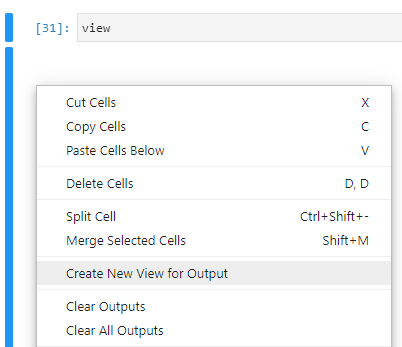

#### Saving the widget state as a screenshot for offline viewing

In some cases, you might want to take a screenshot of the current state of the widget (e.g. to save a static preview). This is a step that involves three separate cells _necessarily_. Although it is very tempting to merge all the cells together, it will _not_ work unless each cell is run separately:

* Show the widget output
* Export the canvas contents from the JavaScript layer to the Python layer
* Export the contents of the Python layer to the cell output

In [36]:
view

NGLWidget(n_components=2)

In [41]:
view.render_image(trim=True, factor=2);

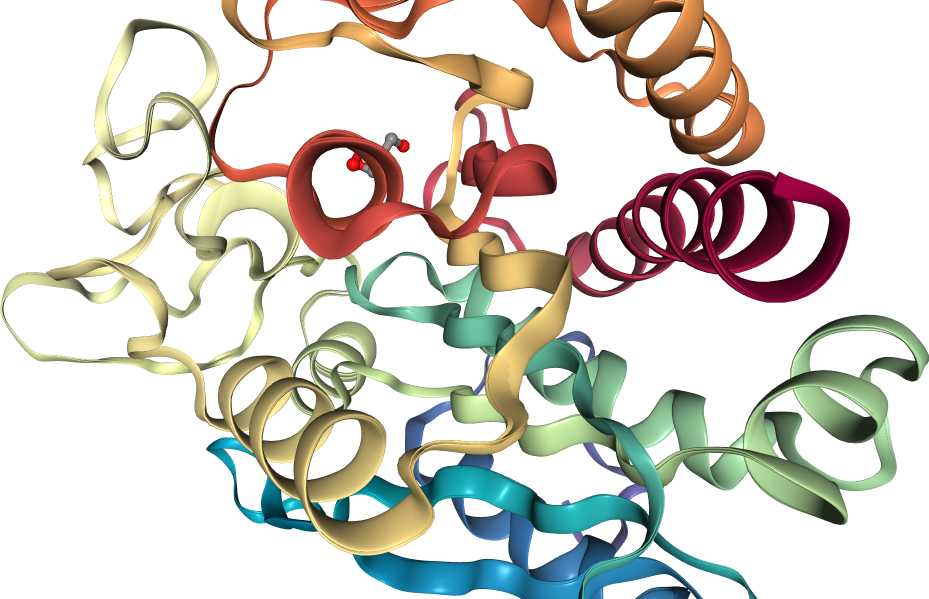

In [42]:
view._display_image()

### Advanced usage
_TODO_

#### Create interactive widget components
_TODO_

#### Access the JavaScript layer
_TODO_

#### Example one: custom tooltips
_TODO_

#### Example two: distance calculations
_TODO_

### Troubleshooting tips
_TODO_

#### Check which Jupyter platform you are working from

_TODO_

#### Fixing your installation
_TODO_


## OLD CONTENT

In [ ]:
# ⚠ This is probably too advanced for this notebook! -> T017
#    Just use a simple visualization with thin cylinders and
#    no interactive widget controls


# JavaScript code needed to update residues around the ligand
# because this part is not exposed in the Python widget
# Based on: http://nglviewer.org/ngl/api/manual/snippets.html
_RESIDUES_AROUND = """
var protein = this.stage.compList[0];
var ligand_center = this.stage.compList[{index}].structure.atomCenter();
var around = protein.structure.getAtomSetWithinPoint(ligand_center, {radius});
var around_complete = protein.structure.getAtomSetWithinGroup(around);
var last_repr = protein.reprList[protein.reprList.length-1];
protein.removeRepresentation(last_repr);
protein.addRepresentation("licorice", {{sele: around_complete.toSeleString()}});
"""


def show_docking(protein, ligands, vina_output):
    # Split the multi PDBQT ligand file into separate files
    ligands_files = split_pdbqt(ligands)
    # Retrieve affinities (we only need that column of the dataframe)
    affinities = parse_output(vina_output)["Affinity (kcal/mol)"]

    # Create viewer widget
    viewer = create_viewer(protein, ligands_files, affinities)

    # Create selection widget
    #   Options is a list of (text, value) tuples. When we click on select, the value will be passed
    #   to the callable registered in `.observe(...)`
    selector = Select(
        options=[(f"#{i} {aff} kcal/mol", i) for (i, aff) in enumerate(affinities, 1)],
        description="",
        rows=len(ligands_files),
        layout=Layout(width="auto"),
    )

    # Arrange GUI elements
    # The selection box will be on the left, the viewer will occupy the rest of the window
    display(AppLayout(left_sidebar=selector, center=viewer, pane_widths=[1, 6, 1]))

    # This is the event handler - action taken when the user clicks on the selection box
    # We need to define it here so it can "see" the viewer variable
    def _on_selection_change(change):
        # Update only if the user clicked on a different entry
        if change["name"] == "value" and (change["new"] != change["old"]):
            viewer.hide(
                list(range(1, len(ligands_files) + 1))
            )  # Hide all ligands (components 1-n)
            component = getattr(viewer, f"component_{change['new']}")
            component.show()  # Display the selected one
            component.center(500)  # Zoom view
            # Call the JS code to show sidechains around ligand
            viewer._execute_js_code(_RESIDUES_AROUND.format(index=change["new"], radius=5))

    # Register event handler
    selector.observe(_on_selection_change)
    # Trigger event manually to focus on the first solution
    _on_selection_change({"name": "value", "new": 1, "old": None})

    return viewer

In the function above we are doing some advanced Python. If you are interested, you can click on the header below to view some more details.

<br />

<details>
    
<summary>Advanced Python explanation</summary>
    
> First you might have noticed is that we are mixing JavaScript and Python code! This is possible thanks to the `ipywidgets` infrastructure, as provided in `NGLViewer.Viewer._execute_js_code`. You can pass a string here (containing JavaScript code) and it will be executed in the NGL widget scope (`this` refers to the interactive canvas). To make it parameterizable, we have added some template placeholders that are formatted on each call to `_on_selection_change`.
>
> This function, `_on_selection_change` is the glue that ties user interactions (clicks on the selection box) to the Python world. It will be called each time you click on the selection box, with a single argument `change`: a dictionary containing the type of event and both the old and new values (so you can compare and do something about it). However, we also need `viewer` to be present in that function... and [we cannot pass additional values](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html#Traitlet-events)!
>
> One way to have `viewer` available in that function is to nest its definition within our `show_docking` function. That way, it will be able to access the outer scope without having to look up in the notebook (global) scope. You have some [more information about scope and closures in this post](https://medium.com/@dannymcwaves/a-python-tutorial-to-understanding-scopes-and-closures-c6a3d3ba0937).

</details>


### Load and draw molecules

Explain what you will do.

In [ ]:
color_map = {
    "hydrophobic": [0.90, 0.10, 0.29],
    "hbond": [0.26, 0.83, 0.96],
    "waterbridge": [1.00, 0.88, 0.10],
    "saltbridge": [0.67, 1.00, 0.76],
    "pistacking": [0.75, 0.94, 0.27],
    "pication": [0.27, 0.60, 0.56],
    "halogen": [0.94, 0.20, 0.90],
    "metal": [0.90, 0.75, 1.00],
}


def show_docking_and_interactions(protein, ligands, vina_output):
    # Split the multi PDBQT ligand file into separate files
    ligands_files = split_pdbqt(ligands)
    # Retrieve affinities (we only need that column of the dataframe)
    affinities = parse_output(vina_output)["Affinity (kcal/mol)"]

    # Create selection widget
    #   Options is a list of (text, value) tuples. When we click on select, the value will be passed
    #   to the callable registered in `.observe(...)`
    selector = Select(
        options=[(f"#{i} {aff} kcal/mol", i - 1) for (i, aff) in enumerate(affinities, 1)],
        description="",
        rows=len(ligands_files),
        layout=Layout(width="auto"),
    )

    # Arrange GUI elements
    # The selection box will be on the left, the viewer will occupy the rest of the window (but it will be added later)
    app = AppLayout(left_sidebar=selector, center=None, pane_widths=[1, 6, 1], height="600px",)

    # This is the event handler - action taken when the user clicks on the selection box
    # We need to define it here so it can "see" the viewer variable
    def _on_selection_change(change):
        # Update only if the user clicked on a different entry
        if change["name"] == "value" and (change["new"] != change["old"]):
            if app.center is not None:
                app.center.close()

            # NGL Viewer
            app.center = viewer = nv.NGLWidget(height="600px", default=True, gui=True)
            prot_component = viewer.add_component(protein, ext="pdbqt")  # add protein
            time.sleep(1)
            lig_component = viewer.add_component(
                ligands_files[change["new"]], ext="pdbqt"
            )  # add selected ligand
            time.sleep(1)
            lig_component.center(duration=500)

            # Add interactions
            interactions_by_site = analyze_interactions(
                f"data/docked_protein_ligand.{change['new']+1}.pdb"
            )
            interacting_residues = []
            for site, interactions in interactions_by_site.items():
                for interaction_type, interaction_list in interactions.items():
                    color = color_map[interaction_type]
                    if len(interaction_list) == 1:
                        continue
                    df_interactions = pd.DataFrame.from_records(
                        interaction_list[1:], columns=interaction_list[0]
                    )
                    for _, interaction in df_interactions.iterrows():
                        name = interaction_type
                        viewer.shape.add_cylinder(
                            interaction["LIGCOO"], interaction["PROTCOO"], color, [0.1], name,
                        )
                        interacting_residues.append(interaction["RESNR"])
            # Display interacting residues
            res_sele = " or ".join([f"({r} and not _H)" for r in interacting_residues])
            res_sele_nc = " or ".join(
                [f"({r} and ((_O) or (_N) or (_S)))" for r in interacting_residues]
            )
            prot_component.add_ball_and_stick(
                sele=res_sele, colorScheme="chainindex", aspectRatio=1.5
            )
            prot_component.add_ball_and_stick(
                sele=res_sele_nc, colorScheme="element", aspectRatio=1.5
            )

    # Register event handler
    selector.observe(_on_selection_change)
    # Trigger event manually to focus on the first solution
    _on_selection_change({"name": "value", "new": 1, "old": None})

    return app

`show_docking_and_interactions` is mostly the same function as `show_docking`, but it will also calculate the PLIP interactions for each selection event. In this case, the event handler is a bit more involved. We have to recreate the NGL viewer for each selection event because the interaction cylinders cannot be manually erased. However, this time there is no JavaScript involved; just pure Python. Recreating the viewer widget from scratch, loading the molecules and calculating the interactions takes more time, though, and as a result the experience is not that dynamic.

## Discussion

We first used event handlers (as registered by `.observe()`) to interactively update the viewer with the selected protein-ligand pose and its surroundings. Then, we extended the visualization using PLIP's automated analysis to draw the interactions in the viewer.

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question